# Mini‑projet - Classifieur Bayésien Naïf (Bernoulli)
**Mathématiques pour Informaticiens - FSGA / Université Quisqueya**

**Enseignant : Geovany Batista Polo LAGUERRE | Data Scientist**

**Semestre 1 - 2025–2026**

Ce notebook contient **tout le nécessaire** pour votre mini‑projet :
- classe `NaiveBayesBernoulli` (avec **lissage de Laplace** déjà implémenté),
- fonctions utilitaires pour lire les données,
- **pipeline robuste** de prédiction (texte libre ou vecteurs binaires) avec `safe_predict`,
- TODO structurés pour vous guider.

## Règles & rendu
- Travail **individuel**. Autorisés : `csv`, `math`, `collections`, `itertools`, `random`, `matplotlib`. **Interdit :** `scikit-learn`.
- Rendez ce notebook **exécuté** (toutes les sorties présentes).  
- Nommez le fichier : `NOM_Prenom_NaiveBayes_Pantalon.ipynb`.

### Barème (rappel)
- Implémentation correcte (utilisation de la classe + pipeline) - 35 pts
- Lissage de Laplace **utilisé** et **interprété** - 15 pts
- Dénombrements & fréquences affichés - 15 pts
- Démo et cas tests pertinents - 15 pts
- Qualité du code & commentaires - 10 pts
- Analyse & limites/pistes - 10 pts

## Classe fournie : `NaiveBayesBernoulli` (lissage de **Laplace** déjà implémenté)
- **À VOUS** d’**utiliser** cette classe dans le pipeline (chargement, fit, prédiction, affichage des comptes, etc.).
- Vous pouvez ajouter de **nouvelles features binaires** (facultatif).

In [217]:
import csv
from collections import Counter, defaultdict
from math import log, exp

class NaiveBayesBernoulli:
    """
    Classifieur Bayésien Naïf (modèle Bernoulli binaire)
    - X : dict binaire {'pas_cher':0/1, 'anglais':0/1, ...}
    - y : 'OUI' / 'NON'
    - Lissage de Laplace (alpha) : déjà implémenté.
    """
    def __init__(self, alpha=1.0):
        self.alpha = float(alpha)
        self.classes_ = []
        self.features_ = []
        self.class_counts_ = Counter()
        self.feature_counts_ = defaultdict(lambda: Counter())
        self.n_ = 0

    def fit(self, X_list, y_list):
        self.n_ = len(y_list)
        self.classes_ = sorted(set(y_list))
        feat = set()
        for X in X_list:
            feat |= set(X.keys())
        self.features_ = sorted(feat)
        self.class_counts_.clear()
        self.feature_counts_.clear()
        for X, y in zip(X_list, y_list):
            self.class_counts_[y] += 1
            for f in self.features_:
                v = int(X.get(f, 0))
                self.feature_counts_[y][(f, v)] += 1
        return self

    def _p_class(self, c):
        return self.class_counts_[c] / self.n_

    def _p_feat_given_class(self, feat, val, c):
        c1 = self.feature_counts_[c][(feat, 1)]
        c0 = self.feature_counts_[c][(feat, 0)]
        tot = c1 + c0
        num = (c1 + self.alpha) if val == 1 else (c0 + self.alpha)
        den = tot + 2*self.alpha
        return num / den

    def predict_proba(self, X):
        scores = {}
        for c in self.classes_:
            s = log(self._p_class(c))
            for f in self.features_:
                v = int(X.get(f, 0))
                s += log(self._p_feat_given_class(f, v, c))
            scores[c] = s
        m = max(scores.values())
        exps = {c: exp(v - m) for c, v in scores.items()}
        Z = sum(exps.values())
        return {c: exps[c]/Z for c in self.classes_}

    def predict(self, X):
        proba = self.predict_proba(X)
        return max(proba, key=proba.get)

def load_csv_binary(path, feature_names=("pas_cher","anglais")):
    X_list, y_list = [], []
    with open(path, newline="", encoding="utf-8") as f:
        for row in csv.DictReader(f):
            X = {feat: int(row[feat]) for feat in feature_names}
            y = row["achat"].strip()
            X_list.append(X); y_list.append(y)
    return X_list, y_list

def pretty_counts(nb: NaiveBayesBernoulli):
    print("Classes :", nb.classes_)
    print("Features:", nb.features_)
    for c in nb.classes_:
        print(f"\nClasse {c} (count={nb.class_counts_[c]})")
        for f in nb.features_:
            c1 = nb.feature_counts_[c][(f,1)]
            c0 = nb.feature_counts_[c][(f,0)]
            tot = c1 + c0
            p1 = (c1 + nb.alpha) / (tot + 2*nb.alpha)
            p0 = (c0 + nb.alpha) / (tot + 2*nb.alpha)
            print(f"  {f}: #1={c1}, #0={c0}, p(1|{c})={p1:.3f}, p(0|{c})={p0:.3f}")

## Pipeline robuste : texte libre → features → prédiction sûre (`safe_predict`)
Cette partie gère les **entrées ad hoc** : texte libre ou dictionnaires imparfaits.
- Normalisation de texte (`normalize_text`)
- Règles simples de détection de mots‑clés (`KEYWORD_RULES`)
- Vectorisation (`text_to_features`)
- Validation de vecteurs (`validate_instance`)
- Prédiction avec **abstention** possible (`safe_predict`)

In [218]:
import re, unicodedata
from typing import Dict, Tuple

def normalize_text(s: str) -> str:
    s = s.lower().strip()
    s = "".join(c for c in unicodedata.normalize("NFD", s) if unicodedata.category(c) != "Mn")
    s = re.sub(r"[^a-z0-9\s]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

KEYWORD_RULES = {
    "pas_cher": [r"\bpas\s*cher\b", r"\bprix\b", r"\bbon\s*plan\b", r"\breduction\b", r"\bpromo\b"],
    "anglais":  [r"\banglais\b", r"\btraduction\b", r"\benglish\b", r"\btranslate\b"],
}
compiled_rules = {feat: [re.compile(pat) for pat in pats] for feat, pats in KEYWORD_RULES.items()}

def text_to_features(query: str, expected_features=("pas_cher","anglais")) -> Dict[str, int]:
    q = normalize_text(query)
    X = {f: 0 for f in expected_features}
    for feat in expected_features:
        if feat in compiled_rules:
            X[feat] = int(any(pat.search(q) for pat in compiled_rules[feat]))
    return X

def validate_instance(x: Dict[str, int], expected_features=("pas_cher","anglais")) -> Tuple[bool, str]:
    if set(x.keys()) != set(expected_features):
        extra = set(x.keys()) - set(expected_features)
        missing = set(expected_features) - set(x.keys())
        return False, f"Features inattendues: {sorted(extra)} ; manquantes: {sorted(missing)}"
    for f in expected_features:
        if x[f] not in (0,1):
            return False, f"Feature {f} doit valoir 0 ou 1 (reçu: {x[f]!r})"
    return True, "OK"

def confidence_from_proba(proba: Dict[str, float]) -> float:
    vals = sorted(proba.values(), reverse=True)
    if len(vals) < 2:
        return 1.0
    return vals[0] - vals[1]

def safe_predict(nb_model, query_or_dict, expected_features=("pas_cher","anglais"), threshold=0.15):
    if isinstance(query_or_dict, str):
        x = text_to_features(query_or_dict, expected_features)
        source = "text"
    else:
        x = dict(query_or_dict)
        source = "dict"
        ok, msg = validate_instance(x, expected_features)
        if not ok:
            return {"status":"INVALID", "reason":msg, "features":x}
    proba = nb_model.predict_proba(x)
    yhat  = max(proba, key=proba.get)
    conf  = confidence_from_proba(proba)
    if conf < threshold:
        return {"status":"ABSTAIN", "reason":f"marge={conf:.3f} < seuil={threshold:.3f}", "features":x, "proba":proba}
    return {"status":"OK", "prediction":yhat, "proba":proba, "confidence":conf, "features":x, "source":source}

## TODO 1 - Charger les données et entraîner le modèle
1. Charger `train_pantalon.csv`.
2. Entraîner `NaiveBayesBernoulli(alpha=1.0)`.  
3. Afficher **comptes** et **probabilités lissées** via `pretty_counts`.

In [219]:
data_path = "train_pantalon.csv"
X_train, y_train = load_csv_binary(data_path, feature_names=("pas_cher","anglais"))
nb = NaiveBayesBernoulli(alpha=1.0).fit(X_train, y_train)
pretty_counts(nb)

Classes : ['NON', 'OUI']
Features: ['anglais', 'pas_cher']

Classe NON (count=76)
  anglais: #1=29, #0=47, p(1|NON)=0.385, p(0|NON)=0.615
  pas_cher: #1=29, #0=47, p(1|NON)=0.385, p(0|NON)=0.615

Classe OUI (count=74)
  anglais: #1=17, #0=57, p(1|OUI)=0.237, p(0|OUI)=0.763
  pas_cher: #1=63, #0=11, p(1|OUI)=0.842, p(0|OUI)=0.158


## TODO 2 - Prédire et comparer (`alpha=1` vs `alpha=0`)
Tester sur : `[1,1]`, `[1,0]`, `[0,1]`, `[0,0]`.  
**Comparer** les probabilités et la classe prédite avec/sans lissage. **Interpréter** en 4–6 lignes.

In [220]:
tests = [
    {"pas_cher":1, "anglais":1},
    {"pas_cher":1, "anglais":0},
    {"pas_cher":0, "anglais":1},
    {"pas_cher":0, "anglais":0},
]

def run_preds(alpha):
    nb = NaiveBayesBernoulli(alpha=alpha).fit(X_train, y_train)
    out = []
    for x in tests:
        proba = nb.predict_proba(x)
        yhat = nb.predict(x)
        out.append((x, {k:round(v,3) for k,v in proba.items()}, yhat))
    return out

print("== Avec lissage alpha=1.0 ==")
for x, proba, yhat in run_preds(1.0):
    print(x, "→", yhat, "| proba:", proba)

print("\n== Sans lissage alpha=0.0 ==")
for x, proba, yhat in run_preds(0.0):
    print(x, "→", yhat, "| proba:", proba)

== Avec lissage alpha=1.0 ==
{'pas_cher': 1, 'anglais': 1} → OUI | proba: {'NON': 0.432, 'OUI': 0.568}
{'pas_cher': 1, 'anglais': 0} → OUI | proba: {'NON': 0.274, 'OUI': 0.726}
{'pas_cher': 0, 'anglais': 1} → NON | proba: {'NON': 0.867, 'OUI': 0.133}
{'pas_cher': 0, 'anglais': 0} → NON | proba: {'NON': 0.763, 'OUI': 0.237}

== Sans lissage alpha=0.0 ==
{'pas_cher': 1, 'anglais': 1} → OUI | proba: {'NON': 0.433, 'OUI': 0.567}
{'pas_cher': 1, 'anglais': 0} → OUI | proba: {'NON': 0.27, 'OUI': 0.73}
{'pas_cher': 0, 'anglais': 1} → NON | proba: {'NON': 0.876, 'OUI': 0.124}
{'pas_cher': 0, 'anglais': 0} → NON | proba: {'NON': 0.774, 'OUI': 0.226}


## TODO 3 - Entrées “ad hoc” (texte libre & validation)
1. Tester `safe_predict` avec des **requêtes texte** (orthographes et variantes).  
2. Tester `safe_predict` avec des **dicts** corrects/incorrects.  
3. Ajuster le **seuil** `threshold` (ex. 0.15 → 0.25) et commenter l'effet.

In [221]:
nb = NaiveBayesBernoulli(alpha=1.0).fit(X_train, y_train)

queries = [
    "pantalon pas cher pour homme",
    "patron pantalon en anglais svp",
    "traduction du mot pantalon",
    "prix d'un pantalon en promo",
    "je cherche des infos sur pantalon"
]

for q in queries:
    res = safe_predict(nb, q, expected_features=("pas_cher","anglais"), threshold=0.15)
    print(q, "=>", res)

print("\n-- Dict invalide --")
bad = {"pas_cher": 2, "anglais": "oui"}
print(safe_predict(nb, bad, threshold=0.15))

print("\n-- Dict valide --")
good = {"pas_cher": 1, "anglais": 0}
print(safe_predict(nb, good, threshold=0.15))

pantalon pas cher pour homme => {'status': 'OK', 'prediction': 'OUI', 'proba': {'NON': 0.2744401365198639, 'OUI': 0.7255598634801362}, 'confidence': 0.45111972696027236, 'features': {'pas_cher': 1, 'anglais': 0}, 'source': 'text'}
patron pantalon en anglais svp => {'status': 'OK', 'prediction': 'NON', 'proba': {'NON': 0.8666707205645554, 'OUI': 0.1333292794354446}, 'confidence': 0.7333414411291108, 'features': {'pas_cher': 0, 'anglais': 1}, 'source': 'text'}
traduction du mot pantalon => {'status': 'OK', 'prediction': 'NON', 'proba': {'NON': 0.8666707205645554, 'OUI': 0.1333292794354446}, 'confidence': 0.7333414411291108, 'features': {'pas_cher': 0, 'anglais': 1}, 'source': 'text'}
prix d'un pantalon en promo => {'status': 'OK', 'prediction': 'OUI', 'proba': {'NON': 0.2744401365198639, 'OUI': 0.7255598634801362}, 'confidence': 0.45111972696027236, 'features': {'pas_cher': 1, 'anglais': 0}, 'source': 'text'}
je cherche des infos sur pantalon => {'status': 'OK', 'prediction': 'NON', 'pro

## TODO 4 - Rapport court (5–8 lignes)
- Hypothèse **naïve** (indépendance conditionnelle **à classe fixée**).  
- Pourquoi elle est pratique (et sa **limite**).  
- Interpréter l’effet du **lissage** à partir de vos résultats.  
- Intérêt de `safe_predict` pour gérer des entrées **bruitées/ad hoc**.

## Visualisation
Carte des scores `p(OUI | pas_cher, anglais)` pour `alpha=1`.

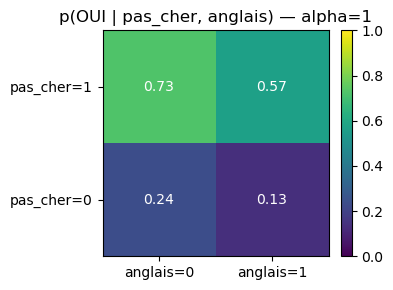

In [222]:
import matplotlib.pyplot as plt
import numpy as np

nb = NaiveBayesBernoulli(alpha=1.0).fit(X_train, y_train)
grid = [(a,b) for a in [0,1] for b in [0,1]]
scores = [ nb.predict_proba({"pas_cher":a,"anglais":b})["OUI"] for a,b in grid ]

fig, ax = plt.subplots(figsize=(4,3))
im = ax.imshow(np.array(scores).reshape(2,2), vmin=0, vmax=1, origin="lower")
ax.set_xticks([0,1]); ax.set_xticklabels(["anglais=0","anglais=1"])
ax.set_yticks([0,1]); ax.set_yticklabels(["pas_cher=0","pas_cher=1"])
for i,(a,b) in enumerate(grid):
    ax.text(b, a, f"{scores[i]:.2f}", ha="center", va="center", color="w")
ax.set_title("p(OUI | pas_cher, anglais) — alpha=1")
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()


# Extension des features & analyses comparatives
Nous étendons le modèle en ajoutant **deux nouvelles features** : `populaire` et `promo`.
Le flux de travail :
1) **Baseline** avec `["pas_cher", "anglais"]`  
2) **Modèle étendu** avec `["pas_cher","anglais","populaire","promo"]`  
3) **Visuels comparatifs** et **TODO d’analyse**.


## Chargement du dataset (train_pantalon.csv)

In [223]:
from pathlib import Path
import pandas as pd

DATA_PATH = "train_pantalon.csv"
df = pd.read_csv(DATA_PATH)
print(df.head(), "\n")
print("Colonnes présentes :", list(df.columns))
print("N =", len(df))

   id  pas_cher  anglais achat
0   1         1        0   OUI
1   2         1        0   OUI
2   3         1        1   OUI
3   4         1        0   OUI
4   5         1        0   OUI 

Colonnes présentes : ['id', 'pas_cher', 'anglais', 'achat']
N = 150


## Utilitaires (chargement X/y, comptages lissés, éval simple)

In [224]:
from collections import Counter
import numpy as np

def load_Xy_from_df(df: pd.DataFrame, feature_names=("pas_cher","anglais")):
    X_list, y_list = [], []
    for _, row in df.iterrows():
        X = {f: int(row[f]) for f in feature_names}
        y = str(row["achat"]).strip().upper()
        X_list.append(X); y_list.append(y)
    return X_list, y_list

def counts_table(nb):
    rows = []
    for c in nb.classes_:
        for f in nb.features_:
            c1 = nb.feature_counts_[c][(f,1)]
            c0 = nb.feature_counts_[c][(f,0)]
            tot = c1 + c0
            p1 = (c1 + nb.alpha) / (tot + 2*nb.alpha)
            p0 = (c0 + nb.alpha) / (tot + 2*nb.alpha)
            rows.append({"classe":c,"feature":f,"#1":c1,"#0":c0,"total":tot,"p(1|classe)":round(p1,3),"p(0|classe)":round(p0,3)})
    priors = {c: nb.class_counts_[c]/nb.n_ for c in nb.classes_}
    return pd.DataFrame(rows), priors

def evaluate_on(df, feature_names):
    X, y = load_Xy_from_df(df, feature_names)
    nb = NaiveBayesBernoulli(alpha=1.0).fit(X,y)
    yhat = [nb.predict(x) for x in X]
    acc = np.mean([a==b for a,b in zip(y,yhat)])
    labels = sorted(set(y))
    conf = pd.DataFrame(0, index=labels, columns=labels)
    for yt, yp in zip(y, yhat):
        conf.loc[yt, yp] += 1
    return nb, acc, conf

## Baseline - features = `['pas_cher','anglais']`

In [225]:
FEATURES_BASE = ["pas_cher","anglais"]
nb_base, acc_base, conf_base = evaluate_on(df, FEATURES_BASE)
tab_base, priors_base = counts_table(nb_base)

print("Priors (baseline) :", {k:round(v,3) for k,v in priors_base.items()})
print("\nComptages & p(1|classe) lissées (baseline):")
display(tab_base)

print("\nConfusion (baseline):")
display(conf_base)
print("\nAccuracy (baseline):", round(acc_base,3))

Priors (baseline) : {'NON': 0.507, 'OUI': 0.493}

Comptages & p(1|classe) lissées (baseline):


,classe,feature,#1,#0,total,p(1|classe),p(0|classe)
0,NON,anglais,29,47,76,0.385,0.615
1,NON,pas_cher,29,47,76,0.385,0.615
2,OUI,anglais,17,57,74,0.237,0.763
3,OUI,pas_cher,63,11,74,0.842,0.158



Confusion (baseline):


,NON,OUI
NON,47,29
OUI,11,63



Accuracy (baseline): 0.733


## Création de `populaire` et `promo` si absents

In [226]:
import numpy as np

def logistic(x):
    return 1 / (1 + np.exp(-x))

def generer_features(df, seed=None,
                     a_pop0=1, b_pop0=3,
                     a_pop1=4, b_pop1=2,
                     a_pro0=1, b_pro0=2,
                     a_pro1=5, b_pro1=2,
                     corr_strength=0.6,
                     soften_determinisme=True):
    """
    - seed=None => tirages différents à chaque run. Fixe une valeur (ex: 123) si tu veux reproductible.
    - corr_strength in [0,1]: 0 = indépendant, 1 = corrélation forte via bruit partagé.
    - soften_determinisme=True : même si pas_cher=1, 'promo' n'est PAS à 100%, juste très probable.
    """

    rng = np.random.default_rng(seed)
    df_ext = df.copy()

    base = df_ext["pas_cher"].astype(int).values
    n = len(df_ext)

    u = rng.normal(0, 1, size=n)
    u = corr_strength * (u - u.mean()) / (u.std() + 1e-9)

    p_pop = np.empty(n, dtype=float)
    mask1 = (base == 1)
    mask0 = ~mask1
    p_pop[mask1] = rng.beta(a_pop1, b_pop1, size=mask1.sum())
    p_pop[mask0] = rng.beta(a_pop0, b_pop0, size=mask0.sum())

    p_pro = np.empty(n, dtype=float)
    p_pro[mask1] = rng.beta(a_pro1, b_pro1, size=mask1.sum())
    p_pro[mask0] = rng.beta(a_pro0, b_pro0, size=mask0.sum())

    alpha = 1.0
    p_pop = logistic(np.log(p_pop/(1-p_pop + 1e-12)) + alpha * u)
    p_pro = logistic(np.log(p_pro/(1-p_pro + 1e-12)) + alpha * u)

    pop = rng.binomial(1, p_pop, size=n)

    if soften_determinisme:
        p_pro[mask1] = 0.5 * p_pro[mask1] + 0.5 * 0.9
    pro = rng.binomial(1, p_pro, size=n)

    if "populaire" not in df_ext.columns:
        df_ext["populaire"] = pop
    if "promo" not in df_ext.columns:
        df_ext["promo"] = pro

    return df_ext

df_ext = generer_features(df, seed=123, corr_strength=0.6)
print(df_ext.head())
print("\nColonnes (étendu) :", list(df_ext.columns))

   id  pas_cher  anglais achat  populaire  promo
0   1         1        0   OUI          1      1
1   2         1        0   OUI          0      1
2   3         1        1   OUI          1      1
3   4         1        0   OUI          0      1
4   5         1        0   OUI          1      1

Colonnes (étendu) : ['id', 'pas_cher', 'anglais', 'achat', 'populaire', 'promo']


## Modèle étendu - features = `['pas_cher','anglais','populaire','promo']`

In [227]:
FEATURES_EXT = ["pas_cher","anglais","populaire","promo"]

nb_ext, acc_ext, conf_ext = evaluate_on(df_ext, FEATURES_EXT)
tab_ext, priors_ext = counts_table(nb_ext)

print("Priors (étendu) :", {k:round(v,3) for k,v in priors_ext.items()})
print("\nComptages & p(1|classe) lissées (étendu):")
display(tab_ext)

print("\nConfusion (étendu):")
display(conf_ext)
print("\nAccuracy (étendu):", round(acc_ext,3))

Priors (étendu) : {'NON': 0.507, 'OUI': 0.493}

Comptages & p(1|classe) lissées (étendu):


,classe,feature,#1,#0,total,p(1|classe),p(0|classe)
0,NON,anglais,29,47,76,0.385,0.615
1,NON,pas_cher,29,47,76,0.385,0.615
2,NON,populaire,25,51,76,0.333,0.667
3,NON,promo,41,35,76,0.538,0.462
4,OUI,anglais,17,57,74,0.237,0.763
5,OUI,pas_cher,63,11,74,0.842,0.158
6,OUI,populaire,47,27,74,0.632,0.368
7,OUI,promo,55,19,74,0.737,0.263



Confusion (étendu):


,NON,OUI
NON,50,26
OUI,15,59



Accuracy (étendu): 0.727


## Visuels comparatifs

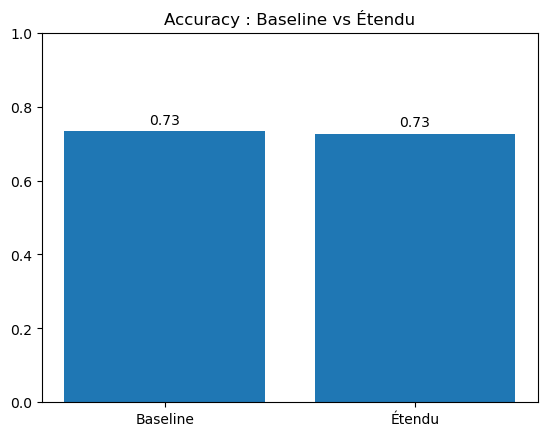

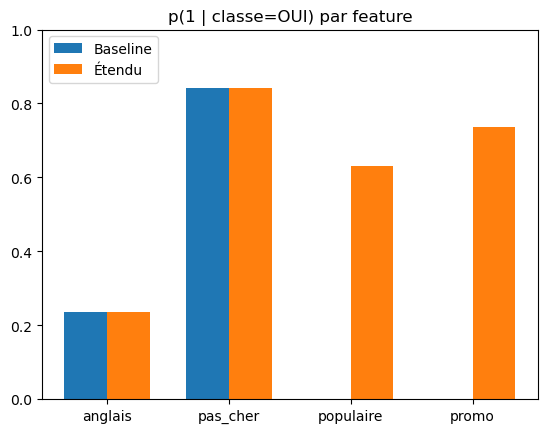

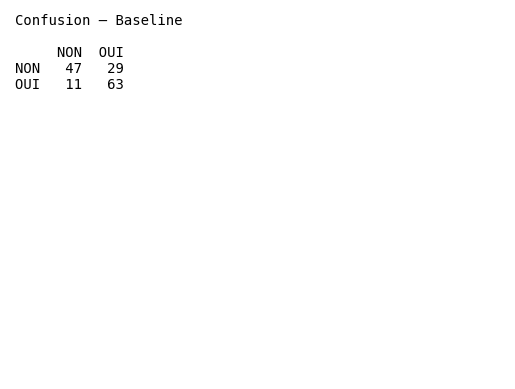

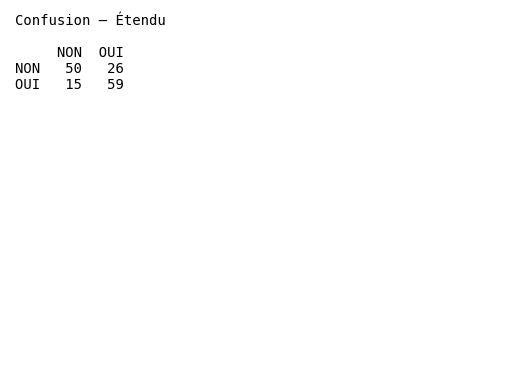

In [228]:
import matplotlib.pyplot as plt

# 1) Accuracy
plt.figure()
plt.bar(["Baseline","Étendu"], [acc_base, acc_ext])
plt.title("Accuracy : Baseline vs Étendu")
plt.ylim(0,1)
for i,val in enumerate([acc_base, acc_ext]):
    plt.text(i, val+0.02, f"{val:.2f}", ha="center")
plt.show()

# 2) p(1|classe=OUI) par feature (baseline vs étendu)
def p1_given_class(tab, classe="OUI"):
    t = tab[tab["classe"]==classe][["feature","p(1|classe)"]].set_index("feature")
    return t["p(1|classe)"]

p1_base = p1_given_class(tab_base, "OUI")
p1_ext  = p1_given_class(tab_ext,  "OUI")

features_all = sorted(set(p1_base.index).union(p1_ext.index))
vals_base = [p1_base.get(f, np.nan) for f in features_all]
vals_ext  = [p1_ext.get(f,  np.nan) for f in features_all]

x = np.arange(len(features_all)); w = 0.35
plt.figure()
plt.bar(x - w/2, vals_base, width=w, label="Baseline")
plt.bar(x + w/2, vals_ext,  width=w, label="Étendu")
plt.xticks(x, features_all, rotation=0)
plt.title("p(1 | classe=OUI) par feature")
plt.legend()
plt.ylim(0,1)
plt.show()

# 3) Matrices de confusion (texte)
def plot_confusion_text(conf, title):
    plt.figure()
    ax = plt.gca()
    ax.axis("off")
    txt = title + "\n\n" + conf.to_string()
    plt.text(0.01, 0.99, txt, va="top", family="monospace")
    plt.show()

plot_confusion_text(conf_base, "Confusion — Baseline")
plot_confusion_text(conf_ext,  "Confusion — Étendu")



## TODO - Analyse à rédiger
1) Comparez les priors et les tableaux de **p(1|classe)** (baseline vs étendu) :  
   - Quelles features sont les plus informatives pour `OUI` ?  
   - L’ajout de `populaire` et `promo` change-t-il l’ordre d’importance ?
2) Comparez les performances :  
   - L’accuracy évolue-t-elle ? Quelles hypothèses pour l’expliquer (corrélation/chevauchement) ?  
   - Où se situent les erreurs (regardez la **confusion**) ?
3) (Option) Calculez la **marge** moyenne (différence entre proba top‑1 et top‑2) avant et après l’extension et commentez l’effet sur la **confiance**.
